# Analysis

## Load Data

In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd

from pathlib import Path
from src.db_utils import get_schema_str
from src.database import SqliteDatabase
from src.spider_sparc_preprocess import (
    load_spider_sparc_data,
    process_all_tables, 
    load_samples_spider,
    load_samples_sparc,
    filter_samples_by_count_sparc,
    filter_samples_by_count_spider, 
    process_samples_sparc,
    process_samples_spider, 
    split_train_dev_test,
    save_samples_spider
)

proj_path = Path('.').resolve()

## Spider Dataset

In [2]:
# spider_path = proj_path / 'data' / 'spider'
# tables, train_data, dev_data = load_spider_sparc_data(spider_path, load_test=False)

# with (proj_path / 'data' / 'description.json').open() as f:
#     all_descriptions = json.load(f)
# spider_tables = process_all_tables(tables, descriptions=all_descriptions)

# # # --------------- split_in_domain ----------------
# all_data = filter_samples_by_count_spider(train_data+dev_data, n=10)
# # process samples -> {db_id: list of samples}
# spider_samples = process_samples_spider(all_data, spider_tables, skip=[])
# # change train/dev by sample
# train_samples, dev_samples, test_samples = split_train_dev_test(spider_samples, train_ratio=0.8, dev_ratio=0.1)

# ------------------ split_by_domain ----------------
# def values_flatten(x: dict[str, list]) -> list:
#     return [item for sublist in x.values() for item in sublist]

# train_samples = process_samples_spider(train_data, spider_tables, skip=[])
# train_samples = values_flatten(train_samples)

# dev_samples = process_samples_spider(dev_data, spider_tables, skip=[])
# dev_samples = values_flatten(dev_samples)
# # test_samples = process_samples_spider(test_data, spider_tables, skip=[])
# test_samples = []
# print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)} | Number of test: {len(test_samples)}')

# save_samples_spider(train_samples, proj_path / 'data' / 'spider_train.json')
# save_samples_spider(dev_samples, proj_path / 'data' / 'spider_dev.json')
# # save_samples_spider(test_samples, proj_path / 'data' / 'spider_test.json')

In [3]:
with (proj_path / 'data' / 'spider' / f'tables.json').open() as f:
    tables = json.load(f)

with (proj_path / 'data' / 'description.json').open() as f:
    all_descriptions = json.load(f)
spider_tables = process_all_tables(tables, descriptions=all_descriptions)

train_samples = load_samples_spider(proj_path / 'data' / 'spider_train.json')
dev_samples = load_samples_spider(proj_path / 'data' / 'spider_dev.json')
# test_samples = load_samples_spider(proj_path / 'data' / 'spider_test.json')
test_samples = []
print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)} | Number of test: {len(test_samples)}')

Number of train: 7000 | Number of dev: 1034 | Number of test: 0


## Test SQL generation

* gpt-4o-mini
* gemini

In [3]:
import os 
from src.spider_sparc_preprocess import DatabaseModel, SpiderSample
from dotenv import load_dotenv, find_dotenv
from collections import defaultdict
from tqdm import tqdm
from langchain_core.runnables import RunnableSequence
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

_ = load_dotenv(find_dotenv())

class Response(BaseModel):
    full_sql_query: str = Field(description='The full SQL query.')
    rationale: list[str] = Field(description='The step-by-step reasoning to generate the SQL query. Each step has ')

# class Response(BaseModel):
#     output: list[OutputFormat]

template = '''### TASK
You are tasked with generating a SQL query(in a SQLite Database) according to a user input request.
You should work in step-by-step reasoning before coming to the full SQL query.

You will be provided an input NL query.

### SCHEMA
You are working with the following schema in a SQLite Database:
{schema}

### FORMATTING
Your output should be of the following JSON format:
{{
    "rationale": "<list[str]: the step-by-step reasoning to generate the SQL query>",
    "full_sql_query": "<str: the full SQL query>"
}}

### OUTPUT
<INPUT QUERY>: {input_query}
<OUTPUT>: 
'''

prompt = PromptTemplate(
    template=template,
    input_variables=['schema', 'input_query']
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0,
)

model = model_openai.with_structured_output(Response)
chain = (prompt | model)

def predict_sql(samples: list[SpiderSample], spider_tables: dict[str, DatabaseModel], chain: RunnableSequence, task: str, k: int = 500, file_name: str = 'full_sql_output') -> list[dict]:
    all_full_sql = list()
    for i, data in tqdm(enumerate(samples), total=len(samples)):
        db_schema = get_schema_str(
            schema=spider_tables[data.db_id].db_schema, 
            foreign_keys=spider_tables[data.db_id].foreign_keys,
            col_explanation=spider_tables[data.db_id].col_explanation
        )
        input_data = {'schema': db_schema, 'input_query': data.final.question}
        output = chain.invoke(input=input_data)

        full_sql_output = {}
        full_sql_output['sample_id'] = data.sample_id
        full_sql_output['db_id'] = data.db_id
        full_sql_output['question'] = data.final.question
        full_sql_output['rationale'] = output.rationale
        full_sql_output['pred_sql'] = output.full_sql_query
        full_sql_output['gold_sql'] = data.final.sql
        full_sql_output['source_tables'] = data.final.source_tables
        all_full_sql.append(full_sql_output)

        if len(all_full_sql) == k:
            with open(proj_path / 'experiments' / task / f'{file_name}_{i//k}.jsonl', 'w') as f:
                for d in all_full_sql:
                    f.write(json.dumps(d) + '\n')
            all_full_sql = list()

    if len(all_full_sql) > 0:
        with open(proj_path / 'experiments' / task / f'{file_name}_{i//k}.jsonl', 'w') as f:
            for d in all_full_sql:
                f.write(json.dumps(d) + '\n')

In [4]:
# task = 'sql_gen_zero_shot_split'
# if not (proj_path / 'experiments' / task).exists():
#     os.makedirs(proj_path / 'experiments' / task)
# train_predictions = predict_sql(train_samples, spider_tables, chain, task, k=500, file_name='spider_train')
# dev_predictions = predict_sql(dev_samples, spider_tables, chain, task, k=500, file_name='spider_dev')
# test_predictions = predict_sql(test_samples, spider_tables, chain, task, k=500, file_name='spider_test')

In [5]:
def load_predictions(task: str, file_pattern: str) -> list[dict]:
    predictions = []
    for p in sorted((proj_path / 'experiments' / task).glob(file_pattern), key=lambda x: int(x.stem.split('_')[-1])):
        with p.open() as f:
            for line in f:
                predictions.append(json.loads(line))
    return predictions

train_predictions = load_predictions('spider_train_*')
dev_predictions = load_predictions('spider_dev_*')

In [6]:
## database execution evaluation
from src.eval import result_eq, check_if_exists_orderby

def get_output_results(predictions: list[dict], spider_tables: dict[str, DatabaseModel]) -> tuple[list[dict], dict[str, list]]:
    output_results = []
    error_infos = {
        'pred_exec': [],
        'gold_exec': [],
        'python_script': [],
        'result': []
    }

    iterator = tqdm(predictions, total=len(predictions))
    for data in iterator:
        iterator.set_description(f'pred_exec: {len(error_infos["pred_exec"])} | gold_exec: {len(error_infos["gold_exec"])} | python_script: {len(error_infos["python_script"])} | result: {len(error_infos["result"])}')
        sample_id = data['sample_id']
        db_id = data['db_id']
        table = spider_tables[db_id]
        database = SqliteDatabase(str(proj_path / 'data' / 'spider' / 'database' / db_id / f'{db_id}.sqlite'), foreign_keys=table.foreign_keys)
        pred_sql = data['pred_sql'] # sqlglot.parse_one(, read='sqlite').sql()
        gold_sql = data['gold_sql']
        question = data['question']
        
        error_info = ''
        try:
            pred_result = database.execute(pred_sql, rt_pandas=False)
        except Exception as e:
            pred_result = []
            error_infos['pred_exec'].append(sample_id)
            error_info = 'Predction Execution Error:' + str(e)
            score = 0
        try:
            gold_result = database.execute(gold_sql, rt_pandas=False)
        except Exception as e:
            error_infos['gold_exec'].append(sample_id)
            error_info = 'Gold Execution Error:' + str(e)

        if 'Gold Execution Error' in error_info:
            continue
        elif 'Predction Execution Error' in error_info:
            output_results.append(
                {
                    'sample_id': sample_id, 
                    'db_id': db_id,
                    'question': question,
                    'score': score,
                    'gold_sql': gold_sql,
                    'pred_sql': pred_sql,
                    'source_tables': data['source_tables'],
                    'error_info': error_info
                }
            )
            continue
        else:
            exists_orderby = check_if_exists_orderby(gold_sql)
            
            try:
                score = int(result_eq(pred_result, gold_result, order_matters=exists_orderby))
            except Exception as e:
                print(f"An error occurred: {e}")
                score = 0
                error_info = 'Python Script Error:' + str(e)
                error_infos['python_script'].append(sample_id)

            if score == 0 and error_info == '':
                error_info = 'Result not equal'
                error_infos['result'].append(sample_id)
            output_results.append(
                {
                    'sample_id': sample_id, 
                    'db_id': db_id,
                    'question': question,
                    'score': score,
                    'gold_sql': gold_sql,
                    'pred_sql': pred_sql,
                    'source_tables': data['source_tables'],
                    'error_info': error_info
                }
            )

    return output_results, error_infos

# train_output_results, train_errors = get_output_results(train_predictions, spider_tables)
# dev_output_results, dev_errors = get_output_results(dev_predictions, spider_tables)

# eval_path = proj_path / 'experiments' / 'evals'
# if not eval_path.exists():
#     eval_path.mkdir()

# with open(eval_path / 'spider_train_eval.json', 'w') as f:
#     json.dump(train_output_results, f)

# with open(eval_path / 'spider_train_errors.json', 'w') as f:
#     json.dump(train_errors, f)

# with open(eval_path / 'spider_dev_eval.json', 'w') as f:
#     json.dump(dev_output_results, f)

# with open(eval_path / 'spider_dev_errors.json', 'w') as f:
#     json.dump(dev_errors, f)

## Complexity of the SQL

```yaml
val: number(float)/string(str)/sql(dict)
col_unit: (agg_id, col_id, isDistinct(bool))
val_unit: (unit_op, col_unit1, col_unit2)
table_unit: (table_type, col_unit/sql)
cond_unit: (not_op, op_id, val_unit, val1, val2)
condition: [cond_unit1, 'and'/'or', cond_unit2, ...]
sql:
    'select': (isDistinct(bool), [(agg_id, val_unit), (agg_id, val_unit), ...])
    'from': {'table_units': [table_unit1, table_unit2, ...], 'conds': condition}
    'where': condition
    'groupBy': [col_unit1, col_unit2, ...]
    'orderBy': ('asc'/'desc', [val_unit1, val_unit2, ...])
    'having': condition
    'limit': None/limit value
    'intersect': None/sql
    'except': None/sql
    'union': None/sql
```

What operations can be happend after the tables are fixed?

1. Selection (SELECT)
    * Knowing which columns contain the required data. User should know business logics to get the logical calculations.
    * Measurement: 1. Number of expressions used. 2. Number of logical calculations and functions used. 
2. Conditioning (WHERE, HAVING)
    * Filtering the data by some logics. User should know the data of the column like data type, distribution, etc. (conditioning on outer join is not included)
    * Measurement: 1. Number of conditions used. 2. Number of kinds of conditions used.
3. Aggregation (GROUP BY)
    * Grouping and aggregating data to get a single value. User should know well about the data of a column.
    * Measurement: 1. Number of expressions used. 2. Number of logical calculations, functions used
4. Nested Queries (Nested, Set Operation)
    * Complex logics that require multiple queries to be executed. User should know the data of the tables and the relationship between them.
    * Measurement: Count of nested queries used.
5. Others: Limiting (LIMIT, OFFSET) & Ordering (ORDER BY) & Distinct(DISTINCT)
    * Limiting the number of rows returned / Sorting the data. User should know the data of the columns.
    * Measurement: 1. If used limiting or ordering or distinct.

* Schema/Data Understanding: Understanding the data stored in the database. This includes the data types, value distributions. (related to the columns and values)
* Business Logic: Domain knowledge, industry-specific calculations, and contextual understanding of values.

In [7]:
eval_path = proj_path / 'experiments' / 'evals'

with open(eval_path / 'spider_train_eval.json') as f:
    train_output_results = json.load(f)

with open(eval_path / 'spider_train_errors.json') as f:
    train_errors = json.load(f)

with open(eval_path / 'spider_dev_eval.json') as f:
    dev_output_results = json.load(f)

with open(eval_path / 'spider_dev_errors.json') as f:
    dev_errors = json.load(f)

In [8]:
import sqlparse
from sqlparse.sql import (
    Token, TokenList, IdentifierList, Identifier, Function, Statement, Parenthesis, Operation,
    Where, Having, Comparison
)
import sqlparse.tokens as tks
from typing import Callable
from pydantic import BaseModel, Field

from src.parsing_sql import (
    Schema, ControlFlow, 
    extract_selection, 
    extract_condition, 
    extract_aggregation, 
    extract_nested_setoperation, 
    extract_others,
    extract_aliases,
    get_source_tables,
)

from src.process_sql import get_schema

#### Table Alias

In [9]:
sql = """
SELECT 
    h1.head_id, 
    h1.name ab,
    h1.name AS abc,
    (h1.name + h1.name) AS abcd, 
    (SELECT name1 FROM head1 hh1 WHERE name1 LIKE '%Ha%') AS abcde,
    (SELECT name2 FROM head2 WHERE name2 LIKE '%Ha%'),
    (SELECT name3 FROM head3 WHERE name3 LIKE '%Ha%') AS abcdef
FROM 
    head h1, 
    (SELECT name4 FROM head4 WHERE name4 LIKE '%Oooo%') h3
JOIN (SELECT name5 nn5 FROM head5 hh5 WHERE name5 LIKE '%Ha%') h2 
ON h1.head_id = h2.head_id
WHERE name6 > (SELECT name6 FROM head6 WHERE name6 LIKE '%Ha%') AND name7 IN (SELECT name7 FROM head7 WHERE name7 LIKE '%Ha%')
GROUP BY h1.head_id
HAVING COUNT(h1.name) > 1
ORDER BY h1.head_id DESC
LIMIT 10
"""
parsed = sqlparse.parse(sql)[0]
result = extract_aliases(parsed)
source_tables = get_source_tables(result)
result, len(source_tables), source_tables


({'table': {'hh1': 'head1',
   'head2': 'head2',
   'head3': 'head3',
   'h1': 'head',
   'head4': 'head4',
   'h3': "(select name4 from head4 where name4 like '%Oooo%')",
   'hh5': 'head5',
   'h2': "(select name5 nn5 from head5 hh5 where name5 like '%Ha%')",
   'head6': 'head6',
   'head7': 'head7'},
  'column': {'ab': 'h1.name',
   'abc': 'h1.name',
   'abcd': '(h1.name + h1.name)',
   'abcde': "(select name1 from head1 hh1 where name1 like '%Ha%')",
   'abcdef': "(select name3 from head3 where name3 like '%Ha%')",
   'nn5': 'name5'}},
 8,
 {'head', 'head1', 'head2', 'head3', 'head4', 'head5', 'head6', 'head7'})

#### Selection

In [10]:
sql = """SELECT name ,  born_state ,  age FROM head ORDER BY age"""
parsed = sqlparse.parse(sql.strip())
statement = parsed[0]
schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / 'department_management' / 'department_management.sqlite'))
schema = Schema(schema)
aliases = extract_aliases(statement)
unique_columns, types = extract_selection(statement, aliases, schema)
print('[SQL]')
print(sqlparse.format(sql, reindent=True).strip())
print('[Alias Mapping]', aliases)
print('[Unique Columns]', unique_columns)
print('[Types]', types)
print()

[SQL]
SELECT name,
       born_state,
       age
FROM head
ORDER BY age
[Alias Mapping] {'table': {'head': 'head'}, 'column': {}}
[Unique Columns] {'__head.name__', '__head.age__', '__head.born_state__'}
[Types] {('__head.age__', '<s>'), ('__head.name__', '<s>'), ('__head.born_state__', '<s>')}



#### Condition

In [11]:
sql = """
SELECT property_name 
FROM Properties 
WHERE property_type_code  =  'House' 
UNION SELECT property_name FROM Properties WHERE property_type_code  =  'Apartment' AND room_count  >  1
"""

statement = sqlparse.parse(sql.strip())[0]
extract_condition(statement)

(["property_type_code = 'House'",
  "property_type_code = 'Apartment'",
  'room_count > 1'],
 {'=', '>'})

#### Aggregation

In [12]:
sql = """SELECT name ,  born_state , AVG(age) FROM head WHERE name LIKE \%Sam\% GROUP BY age ORDER BY age"""
parsed = sqlparse.parse(sql.strip())
statement = parsed[0]
schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / 'department_management' / 'department_management.sqlite'))
schema = Schema(schema)
aliases = extract_aliases(statement)
unique_columns, types = extract_aggregation(statement, aliases, schema)
print('[SQL]')
print(sqlparse.format(sql, reindent=True).strip())
print('[Alias Mapping]', aliases)
print('[Unique Columns]', unique_columns)
print('[Types]', types)
print()

[SQL]
SELECT name,
       born_state,
       AVG(age)
FROM head
WHERE name LIKE \%Sam\%
GROUP BY age
ORDER BY age
[Alias Mapping] {'table': {'head': 'head'}, 'column': {}}
[Unique Columns] {'__head.age__'}
[Types] {('__head.age__', '<s>')}



#### Nested Queries

In [13]:
sql = """
SELECT head_id, (SELECT name FROM head WHERE name LIKE '%Ha%')
FROM head
JOIN (SELECT name FROM head WHERE name LIKE '%Ha%') ON head_id = head_id
WHERE head NOT IN (SELECT name FROM head WHERE name LIKE '%Hooooo%')
UNION 
SELECT head_id, name
FROM (SELECT head_id FROM head WHERE name LIKE '%Ha%') WHERE (SELECT head_id FROM head WHERE name LIKE '%Ha%') IN (3, 4)
GROUP BY head_id
HAVING (SELECT name FROM head WHERE name LIKE '%Ha%')
"""

parsed = sqlparse.parse(sql.strip())
statement = parsed[0]
extract_nested_setoperation(statement)

8

#### Others: Distinct, Limit, Order By

In [14]:
sql = """SELECT DISTINCT head_id, COUNT(DISTINCT name), COUNT(name) FROM head GROUP BY head_id ORDER BY head_id, COUNT(name) LIMIT 10"""
parsed = sqlparse.parse(sql.strip())
statement = parsed[0]

aliases = extract_aliases(statement)
schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / 'department_management' / 'department_management.sqlite'))
schema = Schema(schema)
others = extract_others(statement, aliases, schema)
others

{'distinct': {'__head.head_id__', '__head.name__'},
 'order by': {'__head.head_id__', 'count(__head.name__)'},
 'limit': True}

#### Extract

In [15]:
from tqdm import tqdm

def get_output_result_plus(output_result, filename: str):
    output_results_plus = []
    errors = []
    for x in tqdm(output_result):
        has_error = False
        schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
        schema = Schema(schema)
        
        for s in ['gold', 'pred']:
            try:
                sql = x[f'{s}_sql']
                statement = sqlparse.parse(sql.strip())[0]
                aliases = extract_aliases(statement)
                selection = extract_selection(statement, aliases, schema)
                condition = extract_condition(statement)
                aggregation = extract_aggregation(statement, aliases, schema)
                nested = extract_nested_setoperation(statement)
                others = extract_others(statement, aliases, schema)
                
                x[s + '_selection'] = list(map(list, selection))
                x[s + '_condition'] = (condition[0], list(condition[1]))
                x[s + '_aggregation'] = list(map(list, aggregation))
                x[s + '_nested'] = nested
                x[s + '_others'] = {'distinct': list(others['distinct']), 
                                    'order by': list(others['order by']), 
                                    'limit': others['limit']}
            except Exception as e:
                has_error = True
                errors.append((x['sample_id'], s, str(e)))
                break
    
        if not has_error:
            output_results_plus.append(x)

    with open(proj_path / 'experiments' / 'evals' / f'{filename}.json', 'w') as f:
        # json.dumps(output_results_plus, f)
        for x in output_results_plus:
            l = json.dumps(x)
            f.write(l + '\n')

    with open(proj_path / 'experiments' / 'evals' / f'{filename}_errors.json', 'w') as f:
        json.dump(errors, f)

    print(f'Report: {len(output_results_plus)}/{len(output_result)} - errors = {len(errors)}')

    return output_results_plus

# with open(proj_path / 'experiments' / 'evals' / 'spider_train_eval.json', 'r') as f:
#     train_output_results = json.load(f)

# with open(proj_path / 'experiments' / 'evals' / 'spider_dev_eval.json', 'r') as f:
#     dev_output_results = json.load(f)

# train_plus = get_output_result_plus(train_output_results, 'spider_train_plus')
# dev_plus = get_output_result_plus(dev_output_results, 'spider_dev_plus')

In [16]:
def reverse_mapping(x: dict):
    def post(li: list):
        return [c for c in li if c != '']
    
    for s in ['gold', 'pred']:
        x[f'{s}_selection'] = set(x[f'{s}_selection'][0]), set(list(map(tuple, x[f'{s}_selection'][1])))
        x[f'{s}_condition'] = (set(sorted(post(x[f'{s}_condition'][0]))), set(post(x[f'{s}_condition'][1])))
        x[f'{s}_aggregation'] = set(x[f'{s}_aggregation'][0]), set(list(map(tuple, x[f'{s}_aggregation'][1])))
        x[f'{s}_others']['distinct'] = set(x[f'{s}_others']['distinct'])
        x[f'{s}_others']['order by'] = set(x[f'{s}_others']['order by'])
    return x

def load_plus_data(filename: str):
    data = []
    with open(proj_path / 'experiments' / 'evals' / f'{filename}.json', 'r') as f:
        for l in f:
            x = reverse_mapping(json.loads(l))
            data.append(x)
    return data

train_plus = load_plus_data('spider_train_plus')
dev_plus = load_plus_data('spider_dev_plus')

### Eval score

In [17]:
from typing import Optional

def partial_match(gold_set, predict_set):
    intersection = gold_set.intersection(predict_set)
    union = gold_set.union(predict_set)
    
    # IoU
    iou = len(intersection) / len(union) if union else 0
    
    # Precision
    precision = len(intersection) / len(predict_set) if predict_set else 0
    
    # Recall
    recall = len(intersection) / len(gold_set) if gold_set else 0
    
    # F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    
    return iou, precision, recall, f1_score

def derive_final_score(gold_sets: list, predict_sets: list):
    # Calculate F1-score for each aspect
    empty_gold = [False if g else True for g in gold_sets]
    empty_pred = [False if p else True for p in predict_sets]
    if all(empty_gold) and all(empty_pred):
        return 1.0
    elif all(empty_gold) and not all(empty_pred):
        # If all gold sets are empty, return None
        return 0.0
    f1_scores = []
    for i, (gold, pred) in enumerate(zip(gold_sets, predict_sets)):
        if not empty_gold[i]:
            *_, f1_score = partial_match(gold, pred)
            f1_scores.append(f1_score)
    assert len(f1_scores) > 0, 'No F1-score calculated'
    # modified weights if the gold set is empty

    weights = [1/len(f1_scores)]*len(f1_scores)
    weighted_f1_score = np.array(f1_scores) * np.array(weights)
    final_score = weighted_f1_score.sum()
    # Combine the scores using the specified weights
    return final_score

def normalize_values(x, min_value=0, max_value=6):
    normalized = (x - min_value) / (max_value - min_value)
    return normalized

def tanh(x: np.ndarray, k: float):
    normalized = normalize_values(x, max_value=k)
    return np.tanh(np.log(1+normalized.sum()))

def derive_complexity(x: list[int], k=6):
    score = tanh(np.array(x), k)
    return score

def eval_selection_aggregation_condition(gold: tuple[set, set], pred: tuple[set, set], k=6):
    # partial match
    final_score = derive_final_score(gold, pred)
    gold_complexity = derive_complexity([len(gold[0]), len(gold[1])], k)
    pred_complexity = derive_complexity([len(pred[0]), len(pred[1])], k)

    return final_score, gold_complexity, pred_complexity

def eval_nested(gold: int, pred: int, k=6):
    if gold == 0 and pred == 0:  # gold is always true
        final_score = 1.0
    elif gold < pred:
        final_score = 0.0
    else:
        final_score = np.round(min(gold, pred) / (max(gold, pred) + 1e-10), 6)
    gold_complexity = derive_complexity([gold], k)
    pred_complexity = derive_complexity([pred], k)
    return final_score, gold_complexity, pred_complexity

def eval_others(gold: dict[str, set|bool], pred: dict[str, set|bool], k=6):
    # partial match
    gold_distinct = gold['distinct']
    pred_distinct = pred['distinct']
    gold_orderby = gold['order by']
    pred_orderby = pred['order by']
    gold_limit = set([int(gold['limit'])])
    pred_limit = set([int(pred['limit'])])
    
    final_score = derive_final_score(
        [gold_distinct, gold_orderby, gold_limit], 
        [pred_distinct, pred_orderby, pred_limit], 
    )
    gold_complexity = derive_complexity([len(gold_distinct), len(gold_orderby), len(gold_limit)], k)
    pred_complexity = derive_complexity([len(pred_distinct), len(pred_orderby), len(pred_limit)], k)

    return final_score, gold_complexity, pred_complexity
    
def eval_all(x, k=6):
    selection_score, selecton_gold_complexity, selection_pred_complexity = \
        eval_selection_aggregation_condition(x['gold_selection'], x['pred_selection'], k)
    condition_score, condition_gold_complexity, condition_pred_complexity = \
        eval_selection_aggregation_condition(x['gold_condition'], x['pred_condition'], k)
    aggregation_score, aggregation_gold_complexity, aggregation_pred_complexity = \
        eval_selection_aggregation_condition(x['gold_aggregation'], x['pred_aggregation'], k)
    nested_score, nested_gold_complexity, nested_pred_complexity = \
        eval_nested(x['gold_nested'], x['pred_nested'], k)
    others_score, others_gold_complexity, others_pred_complexity = \
        eval_others(x['gold_others'], x['pred_others'], k)
    
    results = {
        'score': {
            'selection': selection_score,
            'condition': condition_score,
            'aggregation': aggregation_score,
            'nested': nested_score,
            'others': others_score
        },
        'complexity': {
            'selection': [selecton_gold_complexity, selection_pred_complexity],
            'condition': [condition_gold_complexity, condition_pred_complexity],
            'aggregation': [aggregation_gold_complexity, aggregation_pred_complexity],
            'nested': [nested_gold_complexity, nested_pred_complexity],
            'others': [others_gold_complexity, others_pred_complexity]
        }
    }
    return results

def eval_all_dataset(data_plus: list[dict]):
    eval_results = []
    for x in tqdm(data_plus):
        results = eval_all(x)
        gold_c = np.mean([x[0] for x in results['complexity'].values()])
        pred_c = np.mean([x[1] for x in results['complexity'].values()])
        new_x = {
            'sample_id': x['sample_id'],
            'db_id': x['db_id'],
            'score': x['score'],
            'question': x['question'],
            'gold_sql': x['gold_sql'],
            'pred_sql': x['pred_sql'],
            'source_tables': x['source_tables'],
            'len_tbls': len(x['source_tables']),
            's_sel': results['score']['selection'],
            's_cond': results['score']['condition'],
            's_agg': results['score']['aggregation'],
            's_nest': results['score']['nested'],
            's_oth': results['score']['others'],
            'gold_c_sel': results['complexity']['selection'][0],
            'gold_c_cond': results['complexity']['condition'][0],
            'gold_c_agg': results['complexity']['aggregation'][0],
            'gold_c_nest': results['complexity']['nested'][0],
            'gold_c_oth': results['complexity']['others'][0],
            'pred_c_sel': results['complexity']['selection'][1],
            'pred_c_cond': results['complexity']['condition'][1],
            'pred_c_agg': results['complexity']['aggregation'][1],
            'pred_c_nest': results['complexity']['nested'][1],
            'pred_c_oth': results['complexity']['others'][1],
            'gold_c': gold_c,
            'pred_c': pred_c
        }
        eval_results.append(new_x)

    df = pd.DataFrame(eval_results)
    return df

# df_eval_train = eval_all_dataset(train_plus)
# df_eval_train.to_csv(proj_path / 'experiments' / 'evals' / 'spider_train_eval_plus.csv', index=False)
# df_eval_dev = eval_all_dataset(dev_plus)
# df_eval_dev.to_csv(proj_path / 'experiments' / 'evals' / 'spider_dev_eval_plus.csv', index=False)

### Experiments for functions

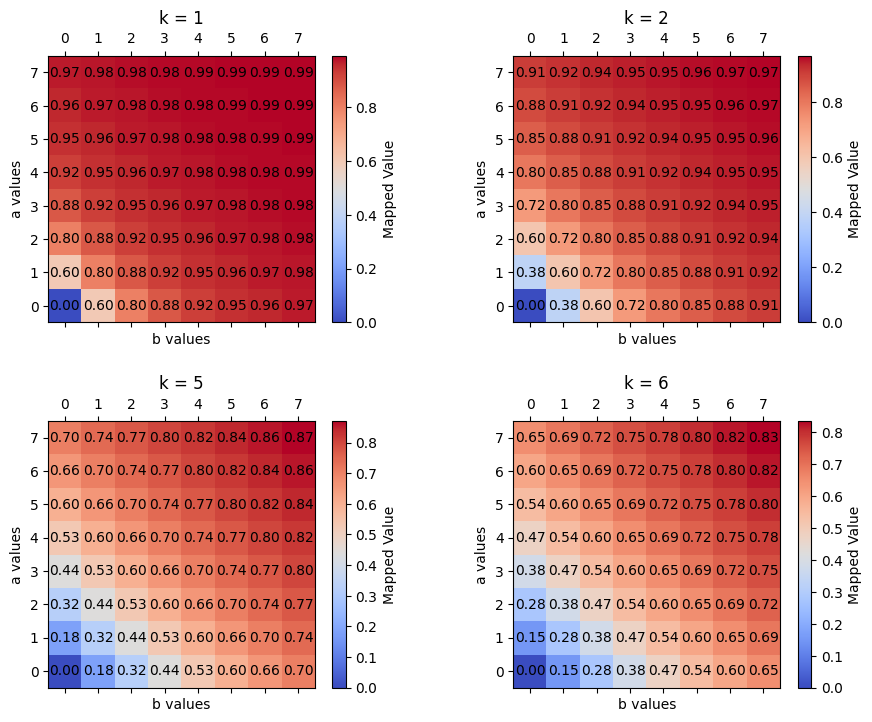

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')

N = 8
a_values = np.arange(0, N, 1)  # Example range from 0 to 9
b_values = np.arange(0, N, 1)  # Example range from 0 to 9

# Create a matrix to hold the results
result_matrix = np.zeros((len(a_values), len(b_values)))
def normalize_values(x, min_value=0, max_value=5):
    normalized = (x - min_value) / (max_value - min_value)
    return normalized

def tanh(x: np.ndarray, k: float):
    normalized = normalize_values(x, max_value=k)
    return np.tanh(np.log(1+normalized.sum()))

def archtan(x: np.ndarray, k: float):
    normalized = normalize_values(x, max_value=k)
    return (2 / np.pi) * np.arctan(normalized.sum())

def sigmoid(x: np.ndarray, k: float=0.1):
    # sigmoid function
    normalized = normalize_values(x, min_value=-k, max_value=k)
    return 1 / (1 + np.exp(-normalized.sum()))

def exponential(x: np.ndarray, k: float=0.1):
    normalized = normalize_values(x, max_value=k)
    return np.exp(-normalized.sum())

func_name = 'tanh'
func = {
    'tanh': tanh,
    'archtan': archtan,
    'sigmoid': sigmoid,
    'exponential': exponential
}[func_name]

result_matrices = {}

ks = [1, 2, 5, 6]
# Populate the matrix with the new function values
for k in ks:
    result_matrices[k] = np.zeros((len(a_values), len(b_values)))
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            result_matrices[k][i, j] = func(np.array([a, b]), k)

# Plot the matrix for the new function
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=5.0)

for i, (k, ax) in enumerate(zip(ks, axes.flatten())):
    # contourf
    # contour = ax.contourf(b_values, a_values, result_matrices[k], levels=50, cmap='viridis')
    matshow = ax.matshow(result_matrices[k], cmap='coolwarm')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('b values')
    ax.set_ylabel('a values')
    ax.invert_yaxis()
    # add numbering 
    for (i, j), val in np.ndenumerate(result_matrices[k]):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
    # Add color bar for each plot
    cbar = fig.colorbar(matshow, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Mapped Value')

plt.show()

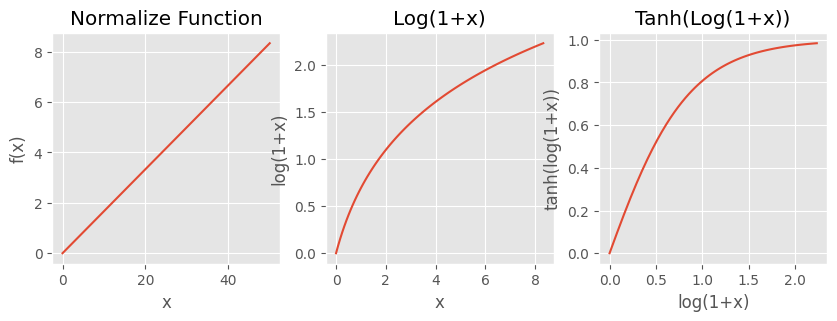

In [29]:
plt.style.use('ggplot')
# plot tanh graph
xx = np.linspace(0, 50, 100)
yy = [tanh(x, 5) for x in xx]

xx2 = normalize_values(xx, max_value=6)
yy2 = np.log(1 + xx2)

yy3 = np.tanh(yy2)
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].plot(xx, xx2)
axes[0].set_title('Normalize Function')
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')

axes[1].plot(xx2, yy2)
axes[1].set_title('Log(1+x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('log(1+x)')

axes[2].plot(yy2, yy)
axes[2].set_title('Tanh(Log(1+x))')
axes[2].set_xlabel('log(1+x)')
axes[2].set_ylabel('tanh(log(1+x))')

plt.show()

## Final Analysis

In [30]:
df1 = pd.read_csv(proj_path / 'experiments' / 'evals' / 'spider_train_eval_plus.csv')
df1['sample_id'] = 'train.' + df1['sample_id'].astype(str)
df2 = pd.read_csv(proj_path / 'experiments' / 'evals' / 'spider_dev_eval_plus.csv')
df2['sample_id'] = 'dev.' + df2['sample_id'].astype(str)
df = pd.concat([df1, df2]).reset_index(drop=True)

df['cate_len_tbls'] = pd.cut(df['len_tbls'], bins=[0, 1, 2, 10], labels=['1', '2', '3+'])

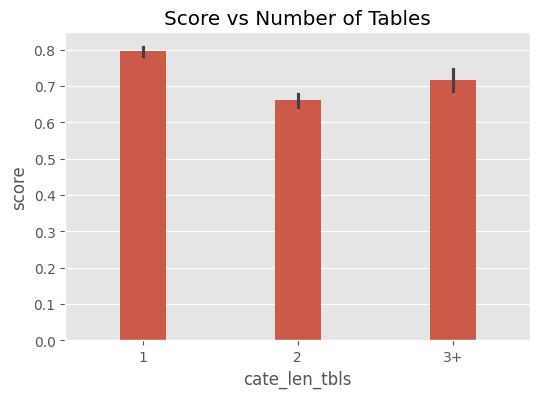

In [31]:
# complexity vs score (group by tables)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(x='cate_len_tbls', y='score', data=df, ax=ax, width=0.3)
ax.set_title('Score vs Number of Tables')
plt.show()

* The number of tables is not the only factor that affects the score to generate the SQL query.

#### Complexity Analysis 

* To argue we should use the complexity of SQL query to evaluate the difficulty of the question.
* Can be candidates for the hueristic method to select BO.

In [32]:
df.loc[:, ['gold_c', 'pred_c', 'gold_c_sel', 'pred_c_sel', 'gold_c_cond', 'pred_c_cond', 'gold_c_agg', 'pred_c_agg', 'gold_c_nest', 'pred_c_nest', 'gold_c_oth', 'pred_c_oth']].describe()

,gold_c,pred_c,gold_c_sel,pred_c_sel,gold_c_cond,pred_c_cond,gold_c_agg,pred_c_agg,gold_c_nest,pred_c_nest,gold_c_oth,pred_c_oth
count,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000
mean,0.165236,0.169597,0.345592,0.351559,0.185057,0.199843,0.068648,0.070221,0.032193,0.024319,0.194689,0.202042
std,0.046505,0.049339,0.115432,0.120459,0.174303,0.176976,0.121230,0.129890,0.081487,0.057860,0.061709,0.065906
min,0.030588,0.030588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152941,0.152941
25%,0.142588,0.142588,0.280000,0.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152941,0.152941
50%,0.168000,0.168000,0.280000,0.280000,0.280000,0.280000,0.000000,0.000000,0.000000,0.000000,0.152941,0.152941
75%,0.194868,0.206118,0.470588,0.470588,0.280000,0.280000,0.000000,0.000000,0.000000,0.000000,0.280000,0.280000
max,0.370868,0.378868,0.800000,0.834862,0.648780,0.689655,0.600000,0.689655,0.470588,0.280000,0.470588,0.470588


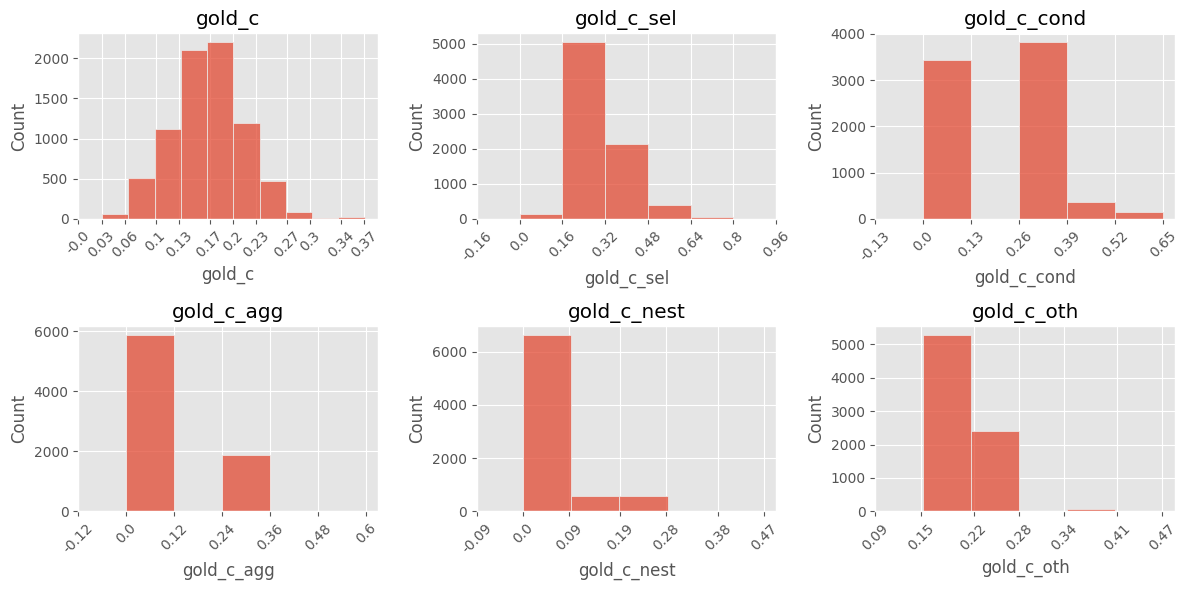

In [33]:
# distribution of target SQL complexity
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, (col, ax, n_bins) in enumerate(zip(['gold_c', 'gold_c_sel', 'gold_c_cond', 'gold_c_agg', 'gold_c_nest', 'gold_c_oth'], axes.flatten(), [10, 5, 5, 5, 5, 5])):
    min_val = df[col].min()
    max_val = df[col].max()
    val_width = max_val - min_val
    bin_width = val_width / n_bins
    sns.histplot(df[col], bins=n_bins, ax=ax, binrange=(min_val, max_val))
    ax.set_title(col)
    ax.set_xticks(np.arange(min_val-bin_width, max_val+bin_width, bin_width).round(2))
    ax.set_xticklabels(np.arange(min_val-bin_width, max_val+bin_width, bin_width).round(2), rotation=45)
plt.tight_layout()
plt.show()

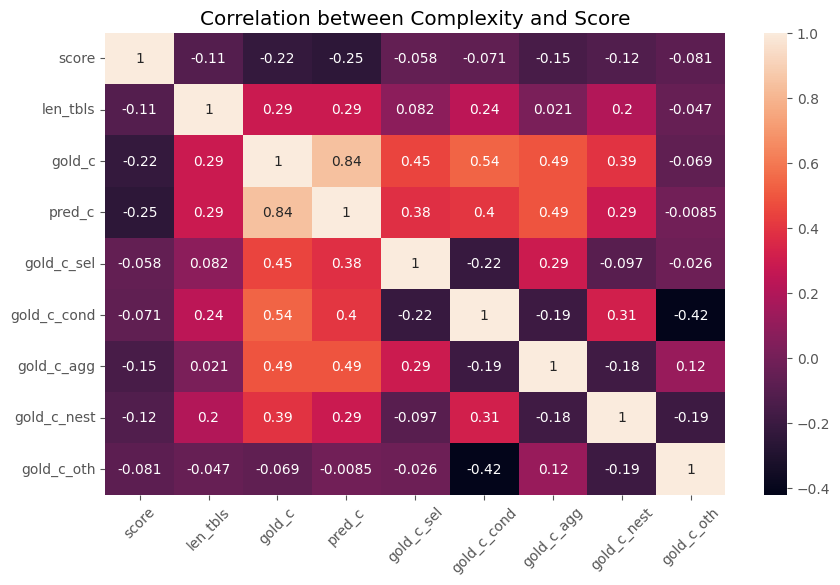

In [34]:
# correlation between complexity and score
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(df.loc[:, ['score', 'len_tbls', 'gold_c', 'pred_c', 'gold_c_sel',  'gold_c_cond', 'gold_c_agg', 'gold_c_nest', 'gold_c_oth']].corr(), annot=True, ax=ax)
ax.set_title('Correlation between Complexity and Score')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

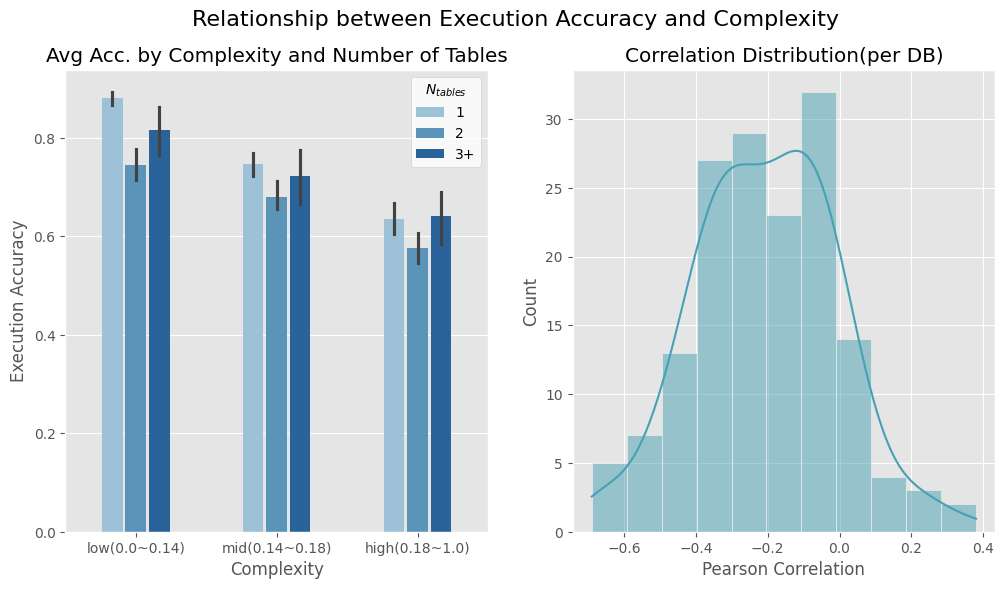

In [35]:
for x in ['gold', 'pred']:
    c_val1, c_val2 = df[f'{x}_c'].quantile(1/3), df[f'{x}_c'].quantile(2/3)
    bins = [-1, c_val1, c_val2, 1]
    labels = [f'low(0.0~{c_val1:.2f})', f'mid({c_val1:.2f}~{c_val2:.2f})', f'high({c_val2:.2f}~1.0)']
    df[f'cate_{x}_c'] = pd.cut(df[f'{x}_c'], bins=bins, labels=labels)
cols = ['cate_gole_c', 'cate_pred_c']

palette = sns.color_palette("Blues", 4).as_hex()[1:]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Average Score vs Target SQL Complexity
bb = sns.barplot(x='cate_gold_c', y='score', hue='cate_len_tbls', data=df, ax=axes[0], palette=palette, width=0.5, gap=0.12, legend=True)
bb.legend_.remove()
axes[0].set_ylabel('Execution Accuracy')
axes[0].set_xlabel('Complexity')
axes[0].set_title('Avg Acc. by Complexity and Number of Tables')

handles, labels = axes[0].get_legend_handles_labels()
lgd = axes[0].legend(handles, labels, title='$N_{tables}$', loc='upper right', bbox_to_anchor=(1.0, 1.0))
lgd.get_frame().set_facecolor('white')

# Correlation Distribution
df_corr = df.loc[:, ['db_id', 'gold_c', 'score']].groupby('db_id')[['score', 'gold_c']].corr().unstack()['gold_c']['score']
df_corr.rename('Pearson Correlation', inplace=True)
sns.histplot(df_corr, bins=10, ax=axes[1], binwidth=0.10, kde=True, color=sns.color_palette("Spectral", 6).as_hex()[5])
axes[1].set_title('Correlation Distribution(per DB)')
axes[1].set_xlabel('Pearson Correlation')

title = 'Relationship between Execution Accuracy and Complexity'
fig.suptitle(title, fontsize=16, y=0.98)
plt.show()

* Higher complexity leads to lower score? Higher complexity tends to have a lower score.
* How about the SQLs for each database? From the pearson correlation, it has a negative correlation with the score.

In [36]:
for x in ['gold', 'pred']:
    for c in ['sel', 'cond', 'agg', 'nest', 'oth']:
        c_val = df[f'{x}_c_{c}'].mean()
        bins = [-1, c_val, 1]
        labels = [f'low(0.0~{c_val:.2f})', f'high({c_val:.2f}~1.0)']
        df[f'cate_{x}_c_{c}'] = pd.cut(df[f'{x}_c_{c}'], bins=bins, labels=labels)

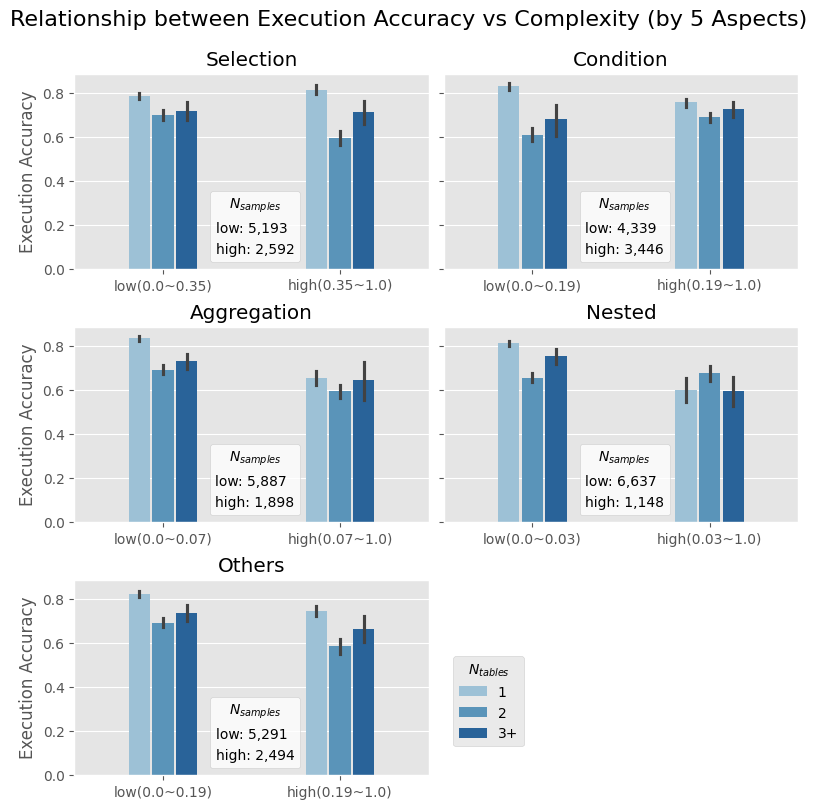

In [37]:
cols = ['cate_gold_c_sel', 'cate_gold_c_cond', 'cate_gold_c_agg', 'cate_gold_c_nest', 'cate_gold_c_oth']
xaxis_labels = ['Selection', 'Condition', 'Aggregation', 'Nested', 'Others']
palette = sns.color_palette("Blues", 4).as_hex()[1:]

fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharey=True)
axes.flatten()[-1].remove()
for i, c in enumerate(cols):
    ax = axes.flatten()[i]
    sns.barplot(x=c, y='score', data=df, hue='cate_len_tbls', errorbar=('ci', 95), palette=palette, ax=ax, legend=True, dodge=True, width=0.4, gap=0.1)
    ax.set_xlabel('')
    ax.set_title(xaxis_labels[i])
    ax.set_ylabel('Execution Accuracy')

    handles, _ = ax.get_legend_handles_labels()
    vs = df[c].value_counts().values
    ls = [f'low: {vs[0]:,}', f'high: {vs[1]:,}']
    lgd = ax.legend(handles, ls, title='$N_{samples}$', loc='lower center', bbox_to_anchor=(0.51, 0.0), handlelength=0, handletextpad=0)
    lgd.get_frame().set_facecolor('white')
    # ax.legend_.remove()


title = 'Relationship between Execution Accuracy vs Complexity (by 5 Aspects)'
fig.suptitle(title, fontsize=16, y=1.0)

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, title='$N_{tables}$', loc='lower center', bbox_to_anchor=(0.60, 0.07))
plt.tight_layout(pad=0.75)
plt.show()

* All the low/high complexity is divided by the average of that complexity.
* when increasing the numbers of table, higher complexity tends to have a lower score in Aggregation, Nested, and Others.

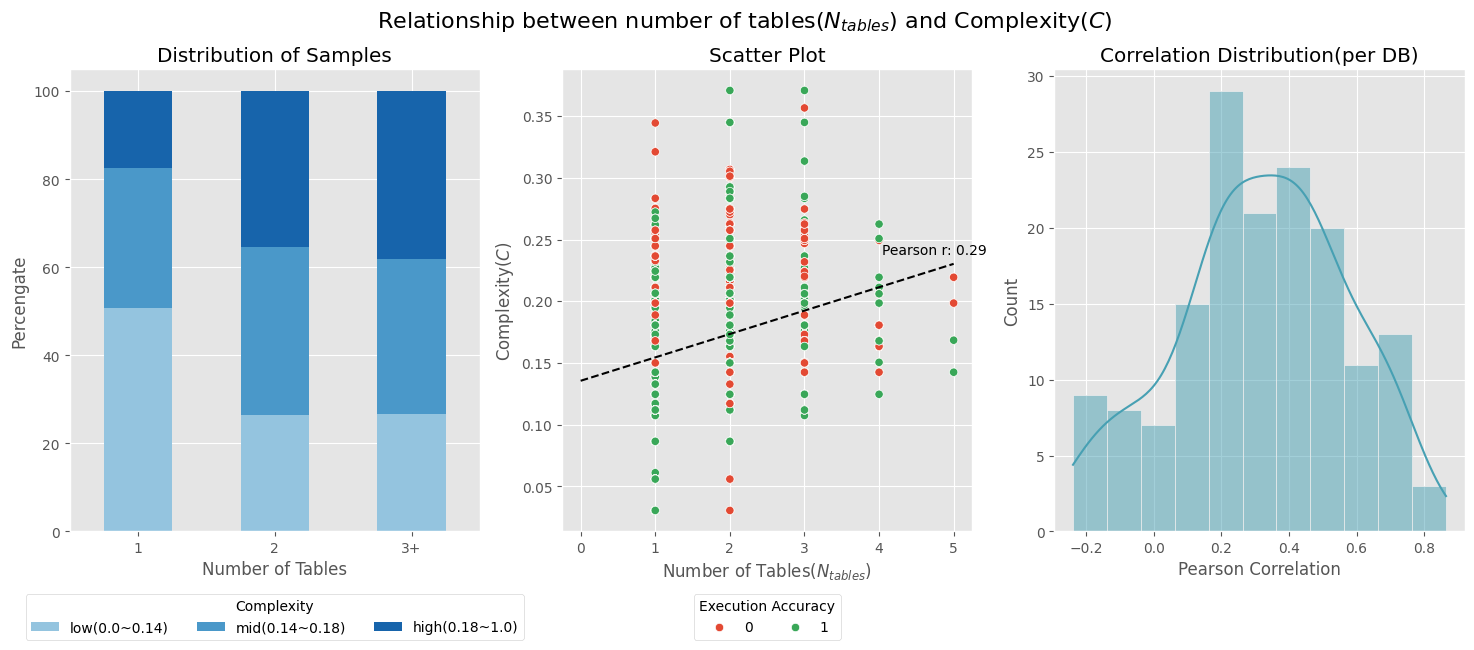

In [38]:
from operator import itemgetter
import scipy as sp
# number of tables vs complexity (stacked bar plot)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
palette = sns.color_palette("Blues", 4).as_hex()[1:]
df_size_len_c = df.loc[:, ['cate_len_tbls', 'cate_gold_c']].groupby(['cate_gold_c', 'cate_len_tbls'], observed=True).size().unstack()
df_size_len_c = df_size_len_c*100 / df_size_len_c.sum(axis=0)
df_size_len_c.T.plot(kind='bar', stacked=True, ax=axes[0], color=palette)
axes[0].set_title('Distribution of Samples')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
lgd = axes[0].legend(title='Complexity', loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
lgd.get_frame().set_facecolor('white')
axes[0].set_xlabel('Number of Tables')
axes[0].set_ylabel('Percengate')

# correlation between number of tables and complexity (scatter plot)
palette = itemgetter(*[0, -1])(sns.color_palette("RdYlGn", 6).as_hex())
sns.scatterplot(x='len_tbls', y='gold_c', data=df, hue='score', palette=palette, ax=axes[1])
axes[1].set_title('Scatter Plot')
axes[1].set_ylabel('Complexity($C$)')
axes[1].set_xlabel('Number of Tables($N_{tables}$)')
axes[1].set_xticks(np.arange(0, 6))
axes[1].set_xticklabels(np.arange(0, 6))
lgd = axes[1].legend(title='Execution Accuracy', loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
lgd.get_frame().set_facecolor('white')
# TODO : add regression line
r, p = sp.stats.pearsonr(x=df['len_tbls'].values, y=df['gold_c'].values)
m, b = np.polyfit(df['len_tbls'].values, df['gold_c'].values, 1)
xx = np.arange(0, 6)
axes[1].plot(xx, xx*m+b, color='black', linestyle='--')
axes[1].text(0.78, 0.60, f'Pearson r: {r:.2f}', transform=axes[1].transAxes)

# correlation between complexity and number of tables by each db_id
df_corr = df.loc[:, ['db_id', 'len_tbls', 'gold_c']].groupby('db_id')[['len_tbls', 'gold_c']].corr().unstack()['gold_c']['len_tbls']
df_corr.rename('Pearson Correlation', inplace=True)
sns.histplot(df_corr, bins=10, ax=axes[2], binwidth=0.10, kde=True, color=sns.color_palette("Spectral", 6).as_hex()[5])
axes[2].set_title('Correlation Distribution(per DB)')
axes[2].set_xlabel('Pearson Correlation')

fig.suptitle('Relationship between number of tables($N_{tables}$) and Complexity($C$)', fontsize=16)
plt.show()

2nd figure: The relationship between the number of tables and the complexity of the SQL query.

* Higher number of table tends to have higher complexity in overall, but it is not always the case. (pearson correlation is about 0.3 in average)

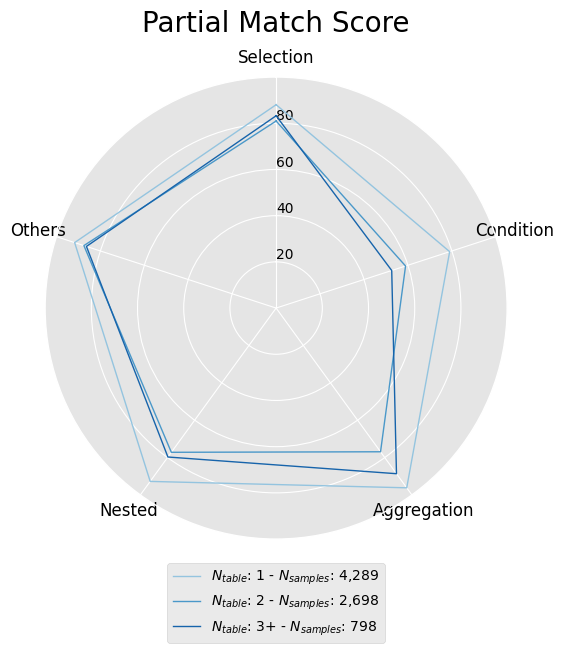

In [39]:
import numpy as np
import matplotlib.pyplot as plt

title = 'Partial Match Score'

df_len_tbls_score = df.groupby(['cate_len_tbls'], observed=False)[['s_sel', 's_cond', 's_agg', 's_nest', 's_oth']].mean()
df_draw = (df_len_tbls_score*100).fillna(0).round(6)
df_n_qs = df.groupby(['cate_len_tbls'], observed=False).size().reset_index(name='n_question').set_index('cate_len_tbls')
cate = df_n_qs.index.tolist()
palette = sns.color_palette("Blues", 4).as_hex()[1:]

# Aspects and their values
aspects = ['Selection', 'Condition', 'Aggregation', 'Nested', 'Others']
N = len(aspects)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.rc('figure', figsize=(6, 6))
ax = plt.subplot(1, 1, 1, polar=True)
 
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], aspects, color='black', size=12)
ax.tick_params(axis='x', rotation=0)

ax.set_rlabel_position(0)
plt.yticks([20,40,60,80], ["20","40","60","80"], color="black", size=10)
plt.ylim(0,100)

for idx in range(len(df_draw)):
    values = df_draw.reset_index().loc[idx].values.tolist()[1:]
    values += values[:1]
    label = '$N_{table}$: ' + f'{cate[idx]}' + ' - ' + '$N_{samples}$: ' + f'{df_n_qs.loc[cate[idx]].values[0]:,}'
    ax.plot(angles, values, color = palette[idx], linewidth=1, linestyle='solid', label=label)
    # ax.fill(angles, values, color = palette[idx], alpha = 0.1, label=label)

ax.set_title(title, fontsize=20, x = 0.5, y = 1.08)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.24))
plt.show()

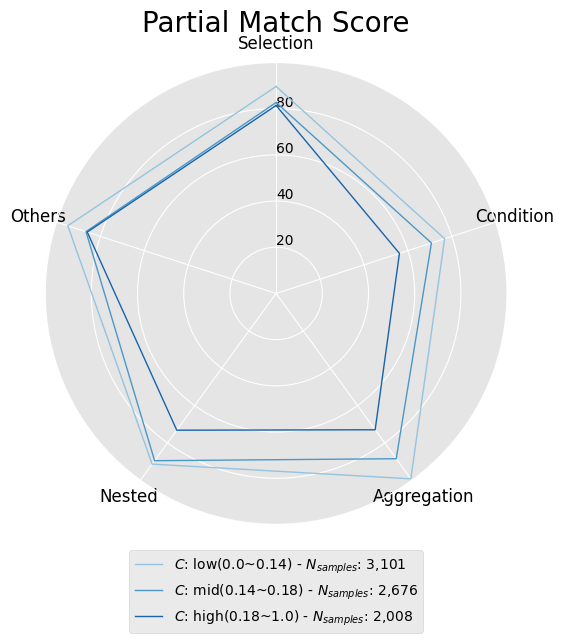

In [40]:
import numpy as np
import matplotlib.pyplot as plt

title = 'Partial Match Score'

df_len_tbls_score = df.groupby(['cate_gold_c'], observed=False)[['s_sel', 's_cond', 's_agg', 's_nest', 's_oth']].mean()
df_draw = (df_len_tbls_score*100).fillna(0).round(6)
df_n_qs = df.groupby(['cate_gold_c'], observed=False).size().reset_index(name='n_question').set_index('cate_gold_c')
cate = df_n_qs.index.tolist()
palette = sns.color_palette("Blues", 4).as_hex()[1:]

# Aspects and their values
aspects = ['Selection', 'Condition', 'Aggregation', 'Nested', 'Others']
N = len(aspects)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.rc('figure', figsize=(6, 6))
ax = plt.subplot(1, 1, 1, polar=True)
 
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], aspects, color='black', size=12)
ax.tick_params(axis='x', rotation=0)

ax.set_rlabel_position(0)
plt.yticks([20,40,60,80], ["20","40","60","80"], color="black", size=10)
plt.ylim(0,100)

for idx in range(len(df_draw)):
    values = df_draw.reset_index().loc[idx].values.tolist()[1:]
    values += values[:1]
    label = '$C$: ' + f'{cate[idx]}' + ' - ' + '$N_{samples}$: ' + f'{df_n_qs.loc[cate[idx]].values[0]:,}'
    ax.plot(angles, values, color = palette[idx], linewidth=1, linestyle='solid', label=label)
    # ax.fill(angles, values, color = palette[idx], alpha = 0.1, label=label)

ax.set_title(title, fontsize=20, x = 0.5, y = 1.05)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))
plt.show()

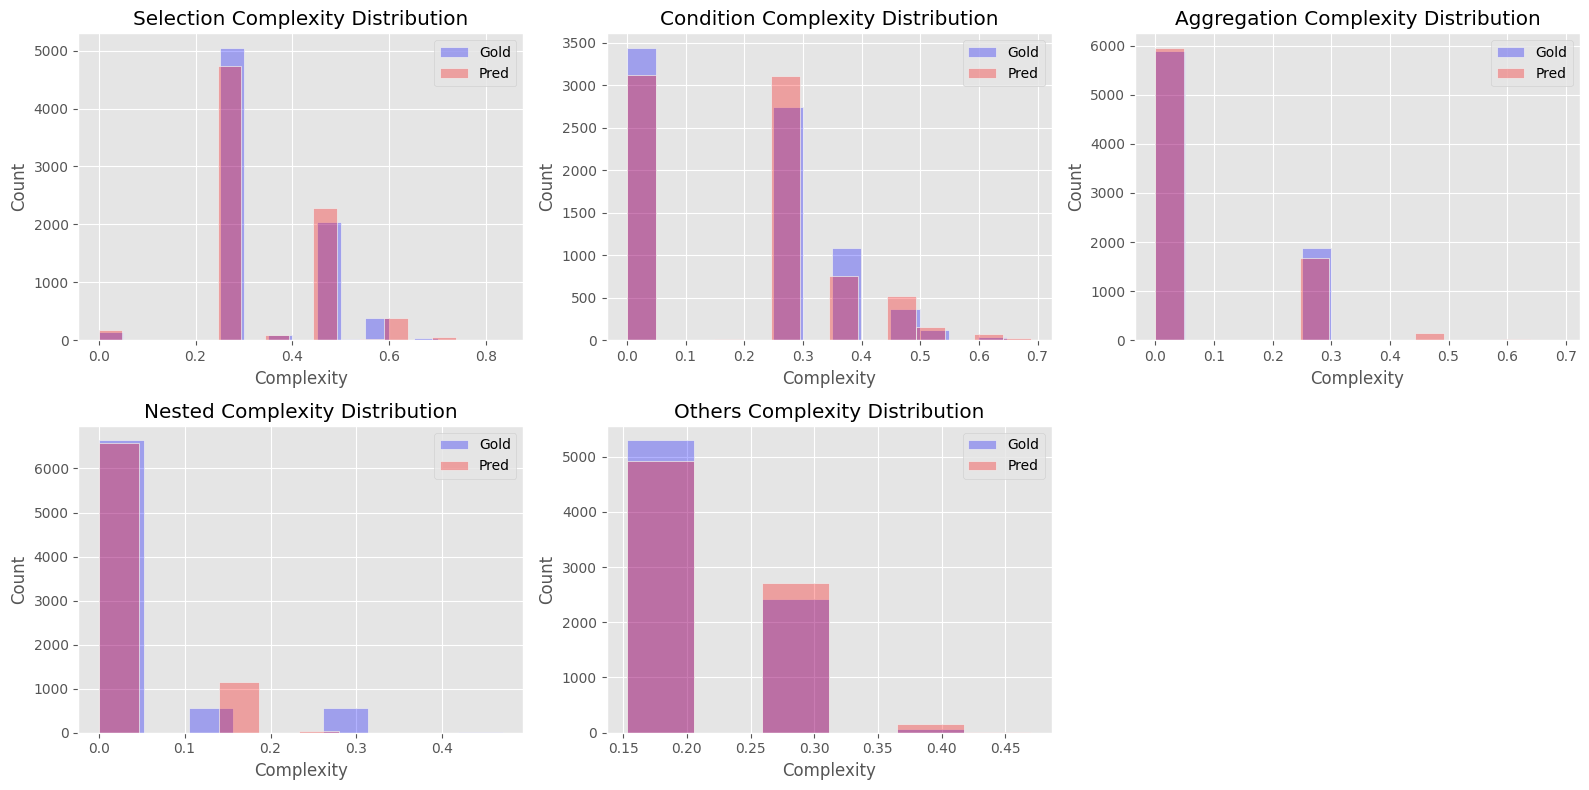

In [41]:
# prediction complexity
aspects = ['Selection', 'Condition', 'Aggregation', 'Nested', 'Others']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, (aspect, ax) in enumerate(zip(['sel', 'cond', 'agg', 'nest', 'oth'], axes.flatten())):
    sns.histplot(df[f'gold_c_{aspect}'], bins=15, color='blue', alpha=0.3, label='Gold', kde=False, ax=ax, binwidth=0.05)
    sns.histplot(df[f'pred_c_{aspect}'], bins=15, color='red', alpha=0.3, label='Pred', kde=False, ax=ax, binwidth=0.05)
    ax.set_title(f'{aspects[i]} Complexity Distribution')
    ax.set_xlabel('Complexity')
    ax.legend()
axes.flatten()[-1].remove()
plt.tight_layout()
plt.show()

In [42]:
df.groupby(['db_id', 'len_tbls'])[['s_sel', 's_cond', 's_agg', 's_nest', 's_oth']].mean().round(4)

s_sel  s_cond   s_agg  s_nest   s_oth
db_id      len_tbls                                        
activity_1 1         0.8875  0.8079  1.0000  1.0000  0.9500
           2         0.7244  0.5458  0.8250  0.6625  0.8750
           3         0.2500  0.1667  0.8750  0.6250  0.7500
aircraft   1         1.0000  0.8182  1.0000  0.9091  0.9091
           2         0.7143  0.5536  0.4286  0.7143  0.8214
...                     ...     ...     ...     ...     ...
world_1    3         1.0000  0.4167  1.0000  0.5000  0.5000
wrestler   1         0.8810  0.7679  1.0000  0.8929  0.9464
           2         1.0000  0.7000  1.0000  0.8000  0.8000
wta_1      1         0.8714  0.8540  0.9565  0.9565  0.9094
           2         0.9500  0.7833  0.7333  0.7000  0.9000

[440 rows x 5 columns]

## Split Train-Dev In Domain(as number of samples)

In [228]:
df_all = df.loc[:, ['sample_id', 'db_id', 'question', 'score', 'gold_sql', 'pred_sql', 'source_tables', 'len_tbls', 'cate_len_tbls', 'gold_c']].copy()

def percentile(x: pd.Series, k: float):
    return x.quantile(k)

# filter index that which score is 0 and the complexity is high by db_id
# current setting is set the complexity by different db_id
df_complexity = df_all.groupby(['db_id'])['gold_c'].agg(['count', 'mean', lambda x: percentile(x, 0.333), lambda x: percentile(x, 0.667), 'max'])
df_complexity.rename(columns={'<lambda_0>': '33%', '<lambda_1>': '67%'}, inplace=True)
df_all['need_high'] = df_all.loc[:, ['db_id', 'gold_c']].apply(lambda x: x['gold_c'] > df_complexity.loc[x['db_id'], '67%'], axis=1)
df_all['need_mid'] = df_all.loc[:, ['db_id', 'gold_c']].apply(lambda x: (x['gold_c'] <= df_complexity.loc[x['db_id'], '67%']) & (x['gold_c'] > df_complexity.loc[x['db_id'], '33%']), axis=1)
df_all['need_low'] = df_all.loc[:, ['db_id', 'gold_c']].apply(lambda x: x['gold_c'] <= df_complexity.loc[x['db_id'], '33%'], axis=1)

df_all['correct'] = df_all['score'] == 1

def need_wrong(x: pd.Series, col: str):
    return (x['score'] != 1) & (x[col] == True)

def need_wrong_cate_len_tbls(x: pd.Series, val: str):
    return (x['score'] != 1) & (x['cate_len_tbls'] == val)

# def notneed_wrong(x: pd.Series, need_type: str):
#     return (x['score'] != 1) & (x[need_type] == False)

for need_type in ['need_high', 'need_mid', 'need_low']:
    df_all[f'{need_type}|wrong'] = df_all.loc[:, ['score', need_type]].apply(need_wrong, col=need_type, axis=1)
    # df_all[f'not{need_type}|wrong'] = df_all.loc[:, ['score', need_type]].apply(notneed_wrong, need_type=need_type, axis=1)

for cate_len_tbl in ['1', '2', '3+']:
    df_all[f'need_{cate_len_tbl}|wrong'] = df_all.loc[:, ['score', 'cate_len_tbls']].apply(need_wrong_cate_len_tbls, val=cate_len_tbl, axis=1)

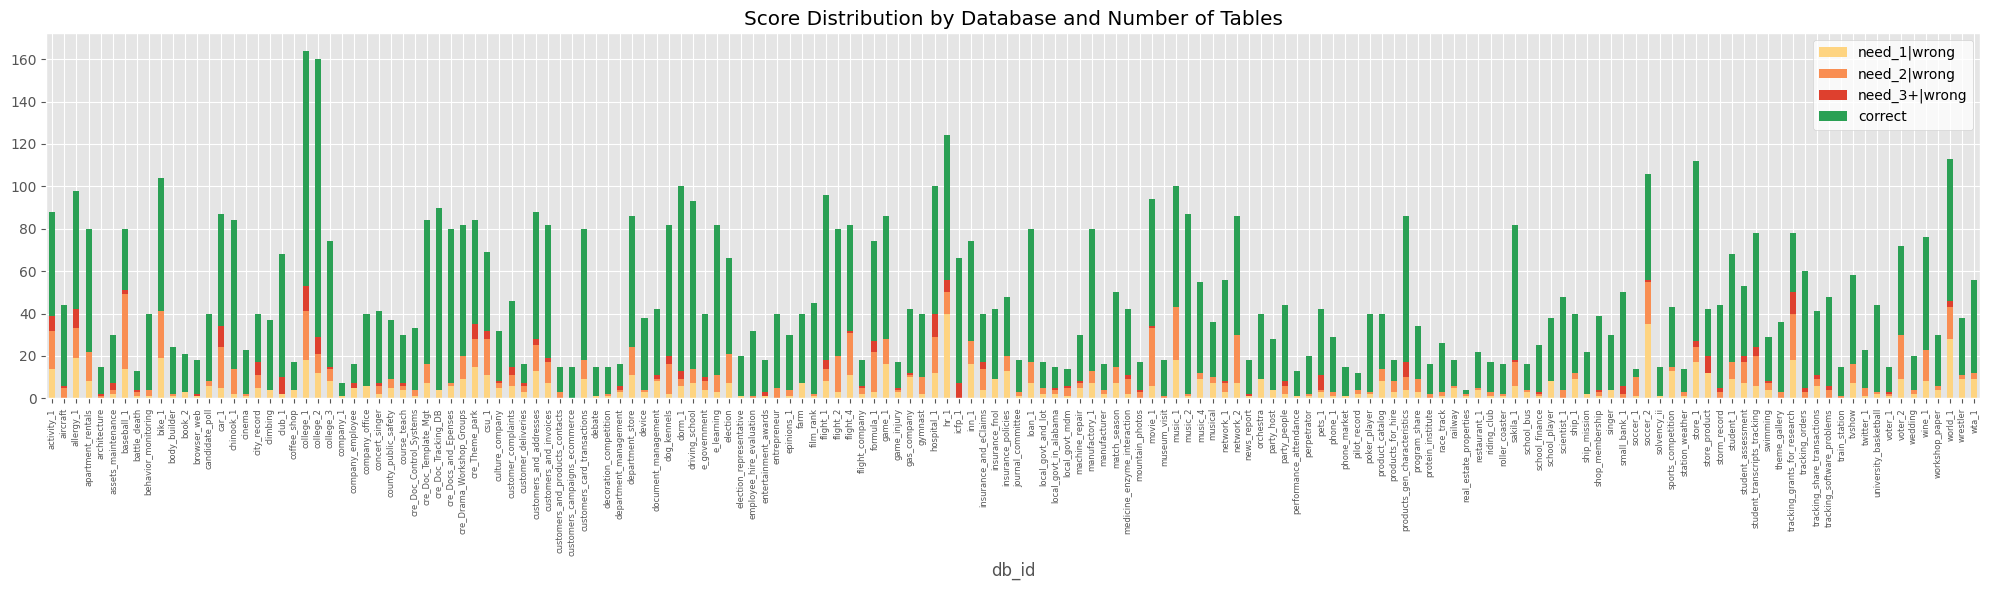

In [229]:
from operator import itemgetter 

df_count = df_all.groupby(['db_id'], observed=True)[['need_1|wrong', 'need_2|wrong', 'need_3+|wrong', 'correct']].sum()
palette = itemgetter(*[2, 1, 0, -1])(sns.color_palette("RdYlGn", 7).as_hex())
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
df_count.plot(kind='bar', y=['need_1|wrong', 'need_2|wrong', 'need_3+|wrong', 'correct'], stacked=True, ax=ax, color=palette)
ax.set_title('Score Distribution by Database and Number of Tables')
lgd = ax.legend(loc='upper right')
lgd.get_frame().set_facecolor('white')
ax.set_xticks(np.arange(len(df_count.index)))
ax.set_xticklabels(df_count.index, fontdict={'fontsize': 6})
plt.tight_layout()
plt.show()


In [240]:
# since we are going to split half of the samples as train and the other half as test
# need to check the condition if we can have at least 1 training sample to create BO
df_check = df_count.loc[:, ['need_1|wrong', 'need_2|wrong', 'need_3+|wrong']].apply(lambda x: np.floor(x * 1/2)).astype(np.int64)
db_ids = df_check.loc[(df_check >= 1).apply(lambda x: all(x), axis=1)].index.tolist()
df_data = df_all.loc[df_all['db_id'].isin(db_ids), :].copy().reset_index(drop=True)
print(f'Number of db_id: {len(db_ids)}, Number of samples: {df_data.loc[~df_data["correct"]].shape[0]}')
df_data.loc[:, ['db_id', 'gold_c', 'score']].groupby('db_id')[['gold_c', 'score']].corr().unstack()['gold_c']['score'].describe()

Number of db_id: 30, Number of samples: 816


count    30.000000
mean     -0.194525
std       0.157654
min      -0.566184
25%      -0.305557
50%      -0.159996
75%      -0.079491
max       0.039800
Name: score, dtype: float64

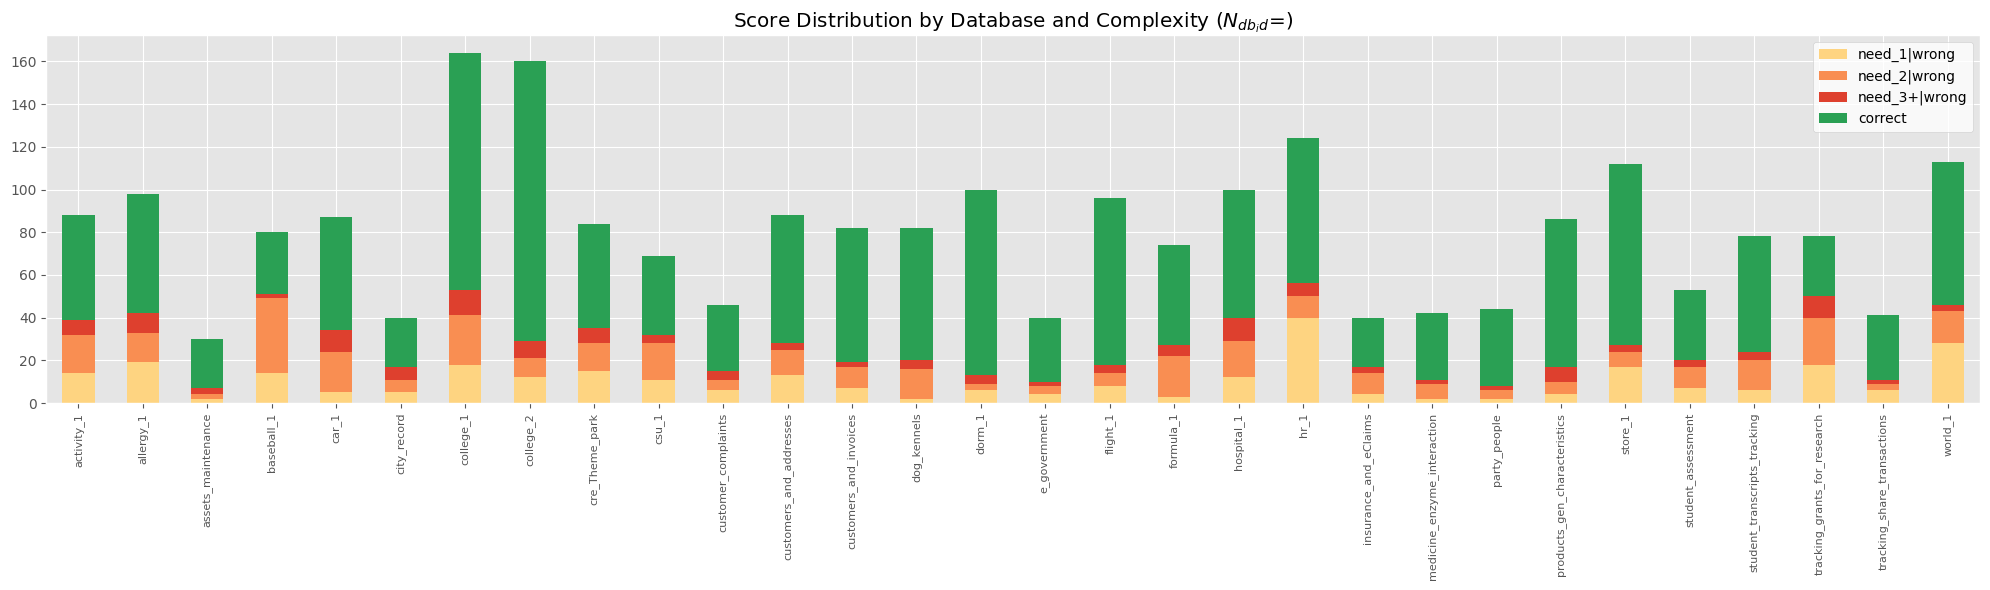

In [231]:
from operator import itemgetter 

df_count3 = df_data.groupby(['db_id'])[['need_1|wrong', 'need_2|wrong', 'need_3+|wrong', 'correct']].sum()
palette = itemgetter(*[2, 1, 0, -1])(sns.color_palette("RdYlGn", 7).as_hex())
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
df_count3.plot(kind='bar', y=['need_1|wrong', 'need_2|wrong', 'need_3+|wrong', 'correct'], stacked=True, ax=ax, color=palette)
ax.set_title('Score Distribution by Database and Complexity ($N_{db_id}$=)')
lgd = ax.legend(loc='upper right')
lgd.get_frame().set_facecolor('white')
ax.set_xticks(np.arange(len(df_count3.index)))
ax.set_xticklabels(df_count3.index, fontdict={'fontsize': 8})
ax.set_xlabel('')
plt.tight_layout()
plt.show()

In [241]:
# cols = ['sample_id', 'db_id', 'question', 'gold_sql', 'source_tables', 'len_tbls', 'cate_len_tbls', 'gold_c', 'need_1|wrong', 'need_2|wrong', 'need_3+|wrong']
# df_train = df_data.loc[(~df_data['correct']), cols].groupby(['db_id', 'need_1|wrong', 'need_2|wrong', 'need_3+|wrong']).sample(frac=0.5).copy()
# train_idx = df_train.index.tolist()
# df_test = df_data.loc[(~df_data['correct']) & (~df_data.index.isin(train_idx)), cols].copy()

# print(f'Number of train samples: {df_train.shape[0]}, Number of test samples: {df_test.shape[0]}')
# print(f'correctly splited?', all(df_train.groupby('db_id').size() + df_test.groupby('db_id').size() == df_data.loc[(~df_data['correct'])].groupby(['db_id'])['db_id'].size()))

# df_train.to_csv(proj_path / 'data' / 'spilt_in_domain' / 'spider_bo_t_train.csv', index=False)
# df_test.to_csv(proj_path / 'data' / 'spilt_in_domain' / 'spider_bo_t_test.csv', index=False)

Number of train samples: 415, Number of test samples: 401
correctly splited? True


#### low/mid/high complexity

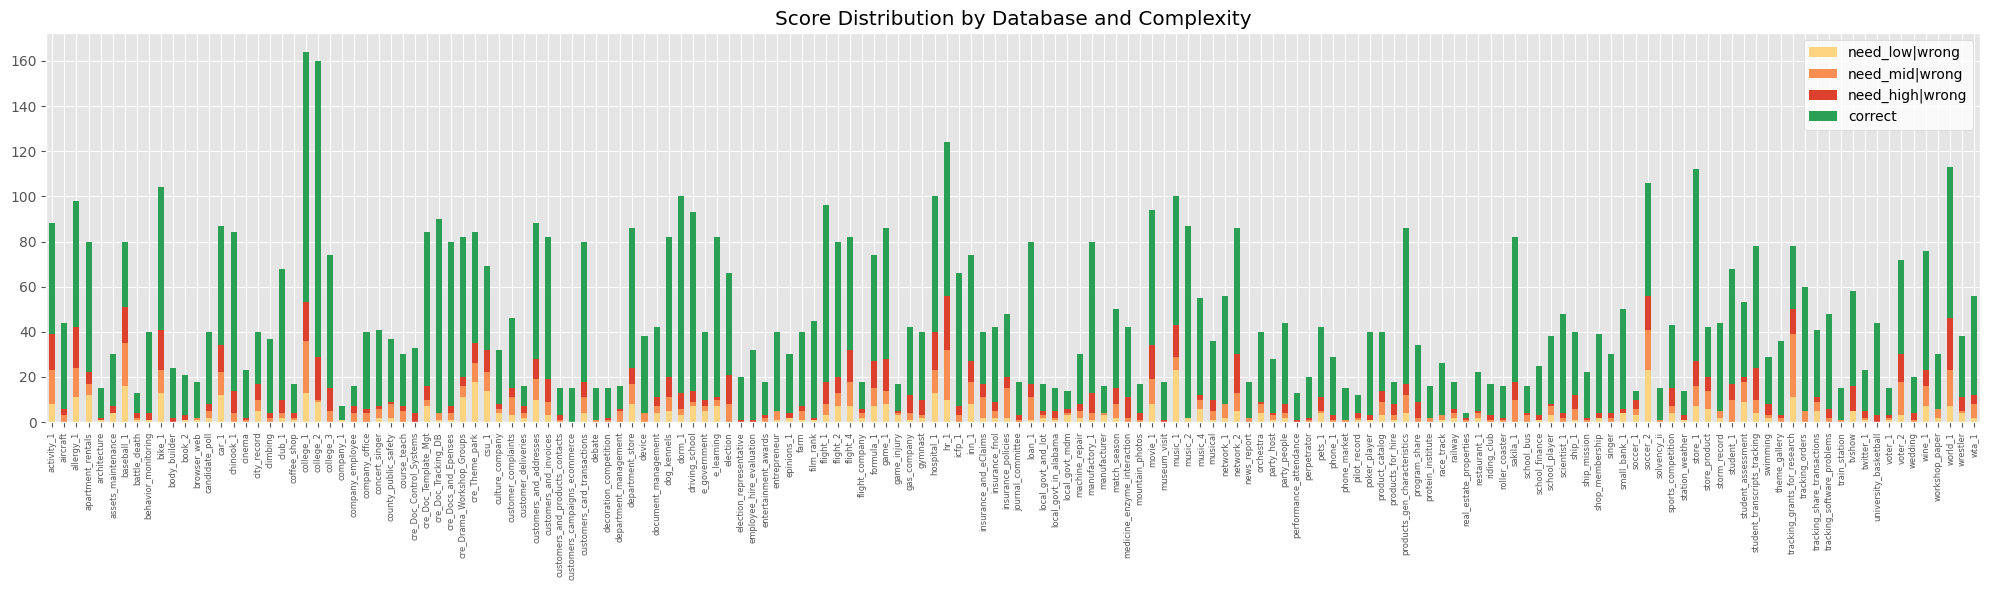

In [236]:
from operator import itemgetter 

df_count2 = df_all.groupby(['db_id'])[['need_low|wrong', 'need_mid|wrong', 'need_high|wrong', 'correct']].sum()
palette = itemgetter(*[2, 1, 0, -1])(sns.color_palette("RdYlGn", 7).as_hex())
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
df_count2.plot(kind='bar', y=['need_low|wrong', 'need_mid|wrong', 'need_high|wrong', 'correct'], stacked=True, ax=ax, color=palette)
ax.set_title('Score Distribution by Database and Complexity')
lgd = ax.legend(loc='upper right')
lgd.get_frame().set_facecolor('white')
ax.set_xticks(np.arange(len(df_count2.index)))
ax.set_xticklabels(df_count2.index, fontdict={'fontsize': 6})
ax.set_xlabel('')
plt.tight_layout()
plt.show()

In [238]:
# since we are going to split half of the samples as train and the other half as test
# need to check the condition if we can have at least 1 training sample to create BO
df_check = df_count2.loc[:, ['need_low|wrong', 'need_mid|wrong', 'need_high|wrong']].apply(lambda x: np.floor(x * 1/2)).astype(np.int64)
db_ids = df_check.loc[(df_check >= 1).apply(lambda x: all(x), axis=1)].index.tolist()
df_data = df_all.loc[df_all['db_id'].isin(db_ids), :].copy().reset_index(drop=True)
print(f'Number of db_id: {len(db_ids)}, Number of samples: {df_data.loc[~df_data["correct"]].shape[0]}')
df_data.loc[:, ['db_id', 'gold_c', 'score']].groupby('db_id')[['gold_c', 'score']].corr().unstack()['gold_c']['score'].describe()

Number of db_id: 61, Number of samples: 1438


count    61.000000
mean     -0.187257
std       0.151115
min      -0.506366
25%      -0.296304
50%      -0.169925
75%      -0.078979
max       0.138333
Name: score, dtype: float64

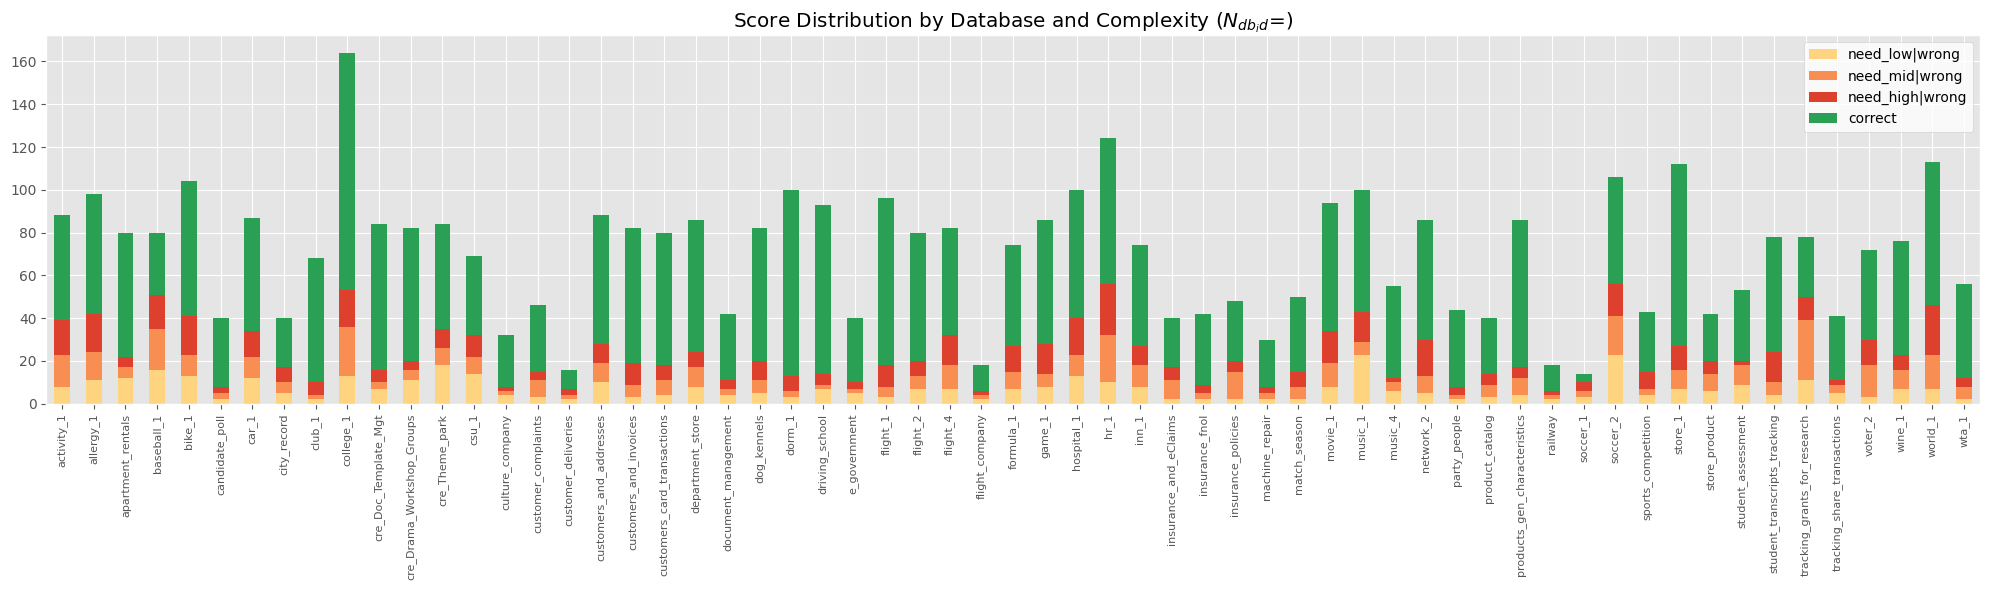

In [234]:
from operator import itemgetter 

df_count4 = df_data.groupby(['db_id'])[['need_low|wrong', 'need_mid|wrong', 'need_high|wrong', 'correct']].sum()
palette = itemgetter(*[2, 1, 0, -1])(sns.color_palette("RdYlGn", 7).as_hex())
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
df_count4.plot(kind='bar', y=['need_low|wrong', 'need_mid|wrong', 'need_high|wrong', 'correct'], stacked=True, ax=ax, color=palette)
ax.set_title('Score Distribution by Database and Complexity ($N_{db_id}$=)')
lgd = ax.legend(loc='upper right')
lgd.get_frame().set_facecolor('white')
ax.set_xticks(np.arange(len(df_count4.index)))
ax.set_xticklabels(df_count4.index, fontdict={'fontsize': 8})
ax.set_xlabel('')
plt.tight_layout()
plt.show()

In [76]:
# cols = ['sample_id', 'db_id', 'question', 'gold_sql', 'source_tables', 'len_tbls', 'cate_len_tbls', 'gold_c', 'need_low|wrong', 'need_mid|wrong', 'need_high|wrong']
# df_train = df_data.loc[(~df_data['correct']), cols].groupby(['db_id', 'need_low|wrong', 'need_mid|wrong', 'need_high|wrong']).sample(frac=0.5).copy()
# train_idx = df_train.index.tolist()
# df_test = df_data.loc[(~df_data['correct']) & (~df_data.index.isin(train_idx)), cols].copy()

# print(f'Number of train samples: {df_train.shape[0]}, Number of test samples: {df_test.shape[0]}')
# print(f'correctly splited?', all(df_train.groupby('db_id').size() + df_test.groupby('db_id').size() == df_data.loc[(~df_data['correct'])].groupby(['db_id'])['db_id'].size()))

# df_train.to_csv(proj_path / 'data' / 'spilt_in_domain' / 'spider_bo_c_train.csv', index=False)
# df_test.to_csv(proj_path / 'data' / 'spilt_in_domain' / 'spider_bo_c_test.csv', index=False)

Number of train samples: 728, Number of test samples: 710
correctly splited? True


### Create BO

In [254]:
import sqlparse
from src.parsing_sql import is_pwn, tks, Statement

LITERALS = [tks.Literal.String.Single, tks.Literal.String.Symbol, tks.Literal.Number.Integer, tks.Literal.Number.Float, tks.Literal.Number.Hexadecimal]
LITERAL_TYPES = dict([(t, str(t.__dict__['parent']).split('.')[-1].upper()) for t in LITERALS])

def get_virtual_table(sql: str):    
    parsed = sqlparse.parse(sql)[0]
    tokens = []
    for token in parsed.flatten():
        if token.ttype in LITERALS:
            token.value = f"[PLACEHOLDER-TYPE:{LITERAL_TYPES[token.ttype]}]"
        tokens.append(token)
    stmt = Statement(tokens)
    return str(stmt)

typ = '_t'  # '_t', '_c'
df_train = pd.read_csv(proj_path / 'data' / 'spilt_in_domain' / f'spider_bo{typ}_train.csv')
df_test = pd.read_csv(proj_path / 'data' / 'spilt_in_domain' / f'spider_bo{typ}_test.csv')
print(f'Number of train samples: {df_train.shape[0]}, Number of test samples: {df_test.shape[0]}')

df_train['virtual_table'] = df_train['gold_sql'].apply(get_virtual_table)
df_test['virtual_table'] = df_test['gold_sql'].apply(get_virtual_table)
# parsed = sqlparse.parse(df_train.loc[0, 'gold_sql'])[0]
# for token in parsed.flatten():
#     if not is_pwn(token):
#         print(token, token.ttype, type(token))

Number of train samples: 415, Number of test samples: 401


In [263]:
import os 
from tqdm import tqdm
from src.spider_sparc_preprocess import DatabaseModel, SpiderSample, SpiderSample, QuestionSQL, BusinessObject
from dotenv import load_dotenv, find_dotenv

from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.runnables import RunnableSequence
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

_ = load_dotenv(find_dotenv())

def predict_sql(
        samples: list[SpiderSample], 
        spider_tables: dict[str, DatabaseModel], 
        chain: RunnableSequence, 
        task: str, 
        k: int = 500, 
        file_name: str = 'full_sql_output',
        vectorstore: Optional[FAISS] = None,
        n_retrieval: int = 1,
        score_threshold: float = 0.65,
    ) -> list[dict]:
    # check index exists, then start from the last index
    check_files = list((proj_path / 'experiments' / task).glob(f'{file_name}_*.jsonl'))
    check_ids = [int(x.stem.split('_')[-1]) for x in check_files]
    if len(check_ids) > 0:
        i = max(check_ids) * k
        samples = samples[i:]
    else:
        i = 0
    
    all_outputs = list()
    for i, data in tqdm(enumerate(samples, i), total=len(samples)):
        db_schema = get_schema_str(
            schema=spider_tables[data.db_id].db_schema, 
            foreign_keys=spider_tables[data.db_id].foreign_keys,
            col_explanation=spider_tables[data.db_id].col_explanation
        )
        final_output = {}
        if task == 'sql_gen_zero_shot':
            input_data = {'schema': db_schema, 'input_query': data.final.question}
        elif 'bo_desc_gen' in task:
            input_data = {'schema': db_schema, 'virtual_table': data.bo.virtual_table}
        elif 'sql_gen_hint' in task:
            # name hint: 'sql_gen_hint_top{n_retrieval}_[low/mid/high or 1/2/3+]_[desc/descvt]'
            assert vectorstore is not None, 'vectorstore is required for hint generation task.'
            assert len(task.split('_')) == 6, f'Invalid task - {task} name hint: sql_gen_hint_top{n_retrieval}_[low/mid/high or 1/2/3+]_[desc/descvt]"'
            hint_type = task.split('_')[-1]
            filter_type = task.split('_')[-2]
            assert filter_type in ['low', 'mid', 'high', '1', '2', '3+'], f'Invalid filter type: {filter_type}'
            assert hint_type in ['desc', 'descvt'], f'Invalid hint type: {hint_type}'

            retriever = vectorstore.as_retriever(
                search_kwargs={'k': n_retrieval, 'score_threshold': score_threshold, 'filter': {'level': filter_type, 'db_id': data.db_id}}
            )
            docs = retriever.invoke(data.final.question)
            hint = ''
            if len(docs) != 0:
                if hint_type == 'desc':
                    hint += 'Descriptions:\n'
                    hint += json.dumps({j: doc.page_content for j, doc in enumerate(docs)}, indent=4)
                elif hint_type == 'descvt':
                    hint += 'Descriptions and Virtual Tables:\n'
                    hint += json.dumps({j: {'description': doc.page_content, 'virtual_table': doc.metadata['virtual_table']} for j, doc in enumerate(docs)}, indent=4)
            hint += '\n'
            input_data = {'schema': db_schema, 'input_query': data.final.question, 'hint': hint}
        else:
            raise ValueError(f'Invalid task: {task}')
        
        output = chain.invoke(input=input_data)

        final_output['sample_id'] = data.sample_id
        final_output['db_id'] = data.db_id
        final_output['question'] = data.final.question
        final_output['rationale'] = output.rationale
        final_output['gold_sql'] = data.final.sql
        final_output['source_tables'] = data.final.source_tables

        if task == 'sql_gen_zero_shot':
            final_output['pred_sql'] = output.output
        elif 'bo_desc_gen' in task:
            final_output['description'] = output.output
            final_output['virtual_table'] = data.bo.virtual_table
        elif 'sql_gen_hint' in task:
            final_output['pred_sql'] = output.output
            final_output['hint'] = input_data['hint']
        else:
            raise ValueError(f'Invalid task: {task}')
        all_outputs.append(final_output)

        if len(all_outputs) == k:
            with open(proj_path / 'experiments' / task / f'{file_name}_{i//k}.jsonl', 'w') as f:
                for d in all_outputs:
                    f.write(json.dumps(d) + '\n')
            all_outputs = list()

    if len(all_outputs) > 0:
        with open(proj_path / 'experiments' / task / f'{file_name}_{i//k}.jsonl', 'w') as f:
            for d in all_outputs:
                f.write(json.dumps(d) + '\n')

def get_bo_sample_data(df):
    data = []
    for i, row in df.iterrows():
        sample = SpiderSample(
            sample_id=row['sample_id'],
            db_id=row['db_id'],
            final=QuestionSQL(
                question=row['question'],
                sql=row['gold_sql'],
                source_tables=eval(row['source_tables']),
            ),
            bo=BusinessObject(
                obj_id=row['sample_id'],
                virtual_table=row['virtual_table'],
                description='' if row.get('description') is None else row['description']
            )
        )
        data.append(sample)
    return data

In [256]:
task = f'bo_desc_gen{typ}'

with (proj_path / 'data' / 'spider' / f'tables.json').open() as f:
    tables = json.load(f)

with (proj_path / 'data' / 'description.json').open() as f:
    all_descriptions = json.load(f)
    
spider_tables = process_all_tables(tables, descriptions=all_descriptions)

if not (proj_path / 'experiments' / task).exists():
    (proj_path / 'experiments' / task).mkdir()
# assert list((proj_path / 'experiments' / task).glob('*')) == [], 'The directory is not empty'

class Response(BaseModel):
    output: str = Field(description='The a clear and concise summary of the complex data model.')
    rationale: list[str] = Field(description='The step-by-step reasoning to generate the SQL query.')

template = '''### TASK
You are tasked with generating a natural language description according to database schema, and a query template.
A query template is a SQL query with placeholders, it will be a 'virtual table'. Later, user can modify the placeholders to generate the full SQL query.
So in the description, you should clearly and concisely describe a summary of the complex data model that is easily understandable to the users.
Please output the description always start with "The virtual table..." and avoid to mention the exact value in the question.

### SQL QUERY TEMPLATE
All the values in the SQL query are replaced with the following placeholders:
- `[PLACEHOLDER-TYPE:STRING]` for string values
- `[PLACEHOLDER-TYPE:NUMBER]` for numeric values


### FORMATTING
Your output should be of the following JSON format:
{{
    "rationale": "<list[str]: the step-by-step reasoning how does the SQL query generated given the question>",
    "description": "<str: the full SQL query>"
}}

### EXAMPLE

#### SCHEMA
[Table and Columns]
Table Name: Employees
  - 'employee_id' (number): Unique identifier for each employee.
  - 'first_name' (text): First name of the employee.
  - 'last_name' (text): Last name of the employee.
  - 'department' (text): Department where the employee works.
  - 'salary' (number): Annual salary of the employee.

#### OUTPUT
<Virtual Table>: SELECT first_name, last_name FROM Employees WHERE department = [PLACEHOLDER-TYPE:STRING];
<OUTPUT>: 
{{
    "rationale": [
        "The query is identifing the relevant table, which is 'Employees'.",
        "Select the columns to display, 'first_name' and 'last_name'.",
        "Add a condition to filter the 'department' column for the specified department using a placeholder for string values."
    ],
    "description": "This virtual table describes the first and last names of employees from the 'Employees' table who belong to a specific department. The placeholder in the WHERE clause represents the department's name."
}}


### SCHEMA
You are working with the following schema in a SQLite Database:
{schema}

### BEGIN
<Virtual Table>: {virtual_table}
<OUTPUT>: 
'''

prompt = PromptTemplate(
    template=template,
    input_variables=['schema', 'sql_template'],
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0,
)

model = model_openai.with_structured_output(Response)
chain = (prompt | model)


In [257]:
def run_bo_desc_gen(proj_path, task, spider_tables, chain, type_exp='_c_train', output_file='spider_bo_desc'):    
    df = pd.read_csv(proj_path / 'data' / 'spilt_in_domain' / f'spider_bo{type_exp}.csv')
    df['virtual_table'] = df['gold_sql'].apply(get_virtual_table)
    samples = get_bo_sample_data(df)
    predict_sql(samples, spider_tables, chain, task, k=100, file_name=f'bo_desc_output{type_exp}')

    bos = []
    for p in sorted((proj_path / 'experiments' / task).glob(f'bo_desc_output{type_exp}_*.jsonl'), key=lambda x: int(x.stem.split('_')[-1])):
        with p.open() as f:
            for line in f:
                bos.append(json.loads(line))

    with (proj_path / 'experiments' / f'{output_file}{type_exp}.jsonl').open('w') as f:
        for bo in bos:
            f.write(json.dumps(bo) + '\n')

    # load the data
    descs = dict()
    with (proj_path / 'experiments' / f'{output_file}{type_exp}.jsonl').open('r') as f:
        for line in f:
            x = json.loads(line)
            descs[x['sample_id']] = x['description']

    df['description'] = df['sample_id'].map(descs)
    df.to_csv(proj_path / 'data' / 'spilt_in_domain' / f'{output_file}{type_exp}.csv', index=False)

# run_bo_desc_gen(proj_path, task, spider_tables, chain, type_exp=f'{typ}_train', output_file='spider_bo_desc')
# run_bo_desc_gen(proj_path, task, spider_tables, chain, type_exp=f'{typ}_test', output_file='spider_bo_desc')

100%|██████████| 401/401 [13:28<00:00,  2.02s/it]
